In [1]:
from finta import TA
import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
symbol = "RELIANCE.NS"
df = yf.download(symbol, start="2014-01-01", end="2025-02-13")
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-01-01 00:00:00+00:00,183.855240,203.164734,205.324844,202.890427,205.141968,5849398
2014-01-02 00:00:00+00:00,181.000610,200.010284,204.810532,198.890228,202.913284,6023632
2014-01-03 00:00:00+00:00,178.776855,197.553009,199.633118,195.438614,199.233093,12833897
2014-01-06 00:00:00+00:00,176.853104,195.427185,197.324432,194.295700,197.061554,13315857
2014-01-07 00:00:00+00:00,174.194977,192.489899,196.570099,192.021301,195.347183,17311470


**JUST BY MAKING USE OF SIMPLE TECHNICAL INDICATORS WE CAN CREATE TRADING STARTEGIES.**

**WHEN FAST MOVING SMA CROSSES SLOW MOVING SMA WE GET A BUY SIGNAL AND VICE VERSA.**

**RSI FACTORS IN THE VOLUME AND GIVES INDICATION OF OVERBUYING AND OVERSELLING. ABOVE 70-OVERBOUGHT. BELOW 30-OVERSOLD.**

**BOLLINGER BANDS INDICATE VOLATILITY AND CAN SIGNAL US ABOUT A POTENTIAL PRICE REVERSAL.**

**MACD GIVES SIGNAL ABOUT UPTREND OR DOWNTREND.**

In [ ]:
a=TA.SMA(df,period=50)
b=TA.SMA(df,period=100)
c=TA.SMA(df,period=200)
d=TA.RSI(df)
e=TA.BBANDS(df)
f=TA.MACD(df)
df_1 = pd.concat([df,a,b,c,d,e,f], axis=1)
df_1.to_csv("rel_stk.csv")

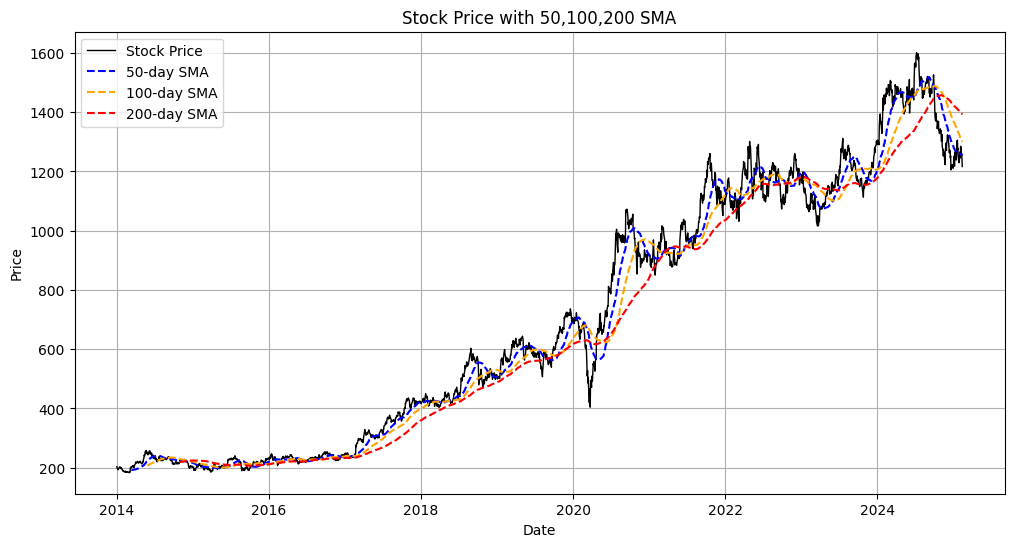

In [13]:
import matplotlib.pyplot as plt

df=pd.read_csv("rel_stk.csv")

df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Stock Price', color='black', linewidth=1)
plt.plot(df['Date'], df['50 period SMA'], label='50-day SMA', color='blue', linestyle='dashed')
plt.plot(df['Date'], df['100 period SMA'], label='100-day SMA', color='orange', linestyle='dashed')
plt.plot(df['Date'], df['200 period SMA'], label='200-day SMA', color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with 50,100,200 SMA')
plt.legend()
plt.grid(True)
plt.show()

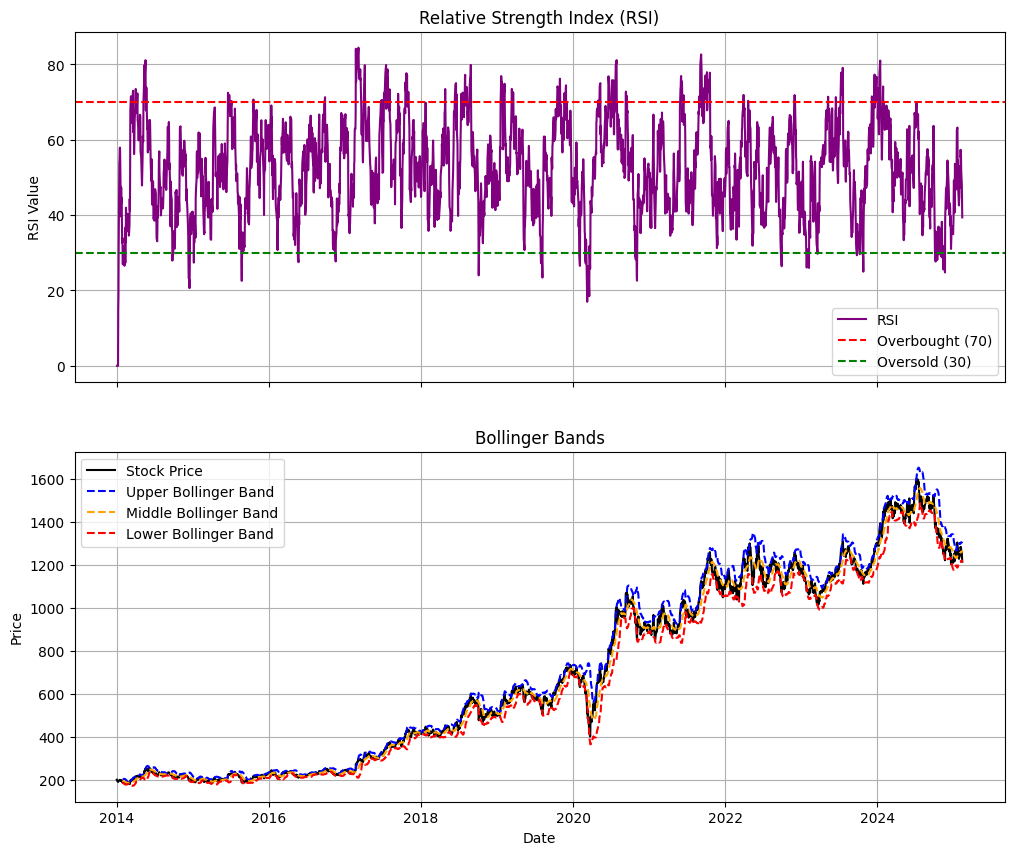

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax[0].plot(df['Date'], df['14 period RSI'], color='purple', label='RSI')
ax[0].axhline(70, color='red', linestyle='dashed', label='Overbought (70)')
ax[0].axhline(30, color='green', linestyle='dashed', label='Oversold (30)')
ax[0].set_ylabel('RSI Value')
ax[0].set_title('Relative Strength Index (RSI)')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df['Date'], df['Close'], color='black', label='Stock Price')
ax[1].plot(df['Date'], df['BB_UPPER'], color='blue', linestyle='dashed', label='Upper Bollinger Band')
ax[1].plot(df['Date'], df['BB_MIDDLE'], color='orange', linestyle='dashed', label='Middle Bollinger Band')
ax[1].plot(df['Date'], df['BB_LOWER'], color='red', linestyle='dashed', label='Lower Bollinger Band')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].set_title('Bollinger Bands')
ax[1].legend()
ax[1].grid(True)

plt.show()

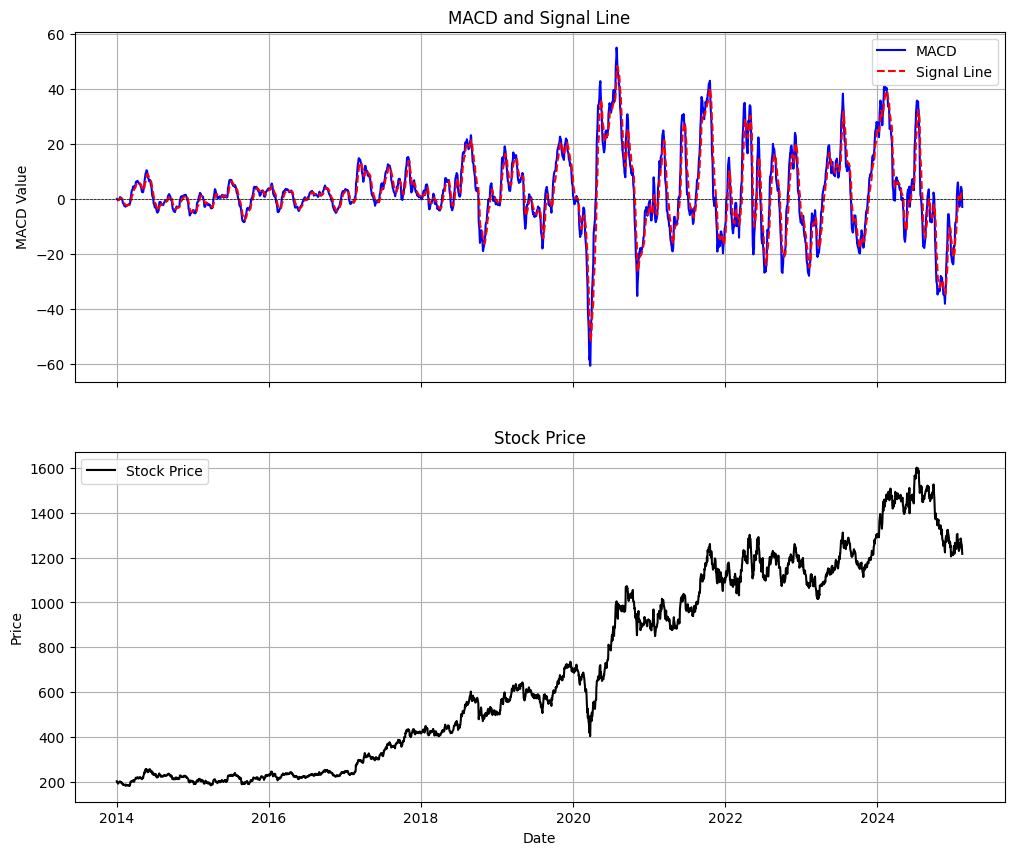

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax[0].plot(df['Date'], df['MACD'], color='blue', label='MACD')
ax[0].plot(df['Date'], df['SIGNAL'], color='red', linestyle='dashed', label='Signal Line')
ax[0].axhline(0, color='black', linestyle='dashed', linewidth=0.5)
ax[0].set_ylabel('MACD Value')
ax[0].set_title('MACD and Signal Line')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df['Date'], df['Close'], color='black', label='Stock Price')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[1].set_title('Stock Price')
ax[1].legend()
ax[1].grid(True)

plt.show()

**WE USE BLACK-SCHOLES-MERTON MODEL TO VALUE OPTIONS**

**FIRST WE FIND THE IMPLIED VOLATILITY USING FMIN**

**WE THEN USE IT AS AN INPUT IN BSM TO FIND VALUES OF CALL AND PUT OPTIONS**

In [69]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fmin
import numpy as np
import scipy.stats as si

def NORMSDIST(x):
    NORMSDIST = si.norm.cdf(x,0.0,1.0)
    return(NORMSDIST)


S = 1216.10  
r = 0.06822  
T = 0.036

df = pd.read_csv("rel_opt.csv")

def ImpliedVolatilityCall(s, X, cmp):
    d1 = ( (np.log(S/X)+(r+0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    of = (  S*NORMSDIST(d1) - X*np.exp(-r*T)*NORMSDIST(d2) ) - cmp
    return of**2
implied_vol = []
for _, row in df.iterrows():
    X = row["Strike Price"]
    cmp = row["Call-Price"]  
    if cmp > 0:  
        s_opt = fmin(ImpliedVolatilityCall, [0.10], args=(X, cmp), disp=False)
        implied_vol.append(round(s_opt[0]*100,2))
    else:
        implied_vol.append(np.nan) 
df["CALL-IV"] = implied_vol

def BSCall(S, X, r, T, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S*NORMSDIST(d1) - X*np.exp(-r*T)*NORMSDIST(d2)
bs_call_prices = []
for _, row in df.iterrows():
    X = row["Strike Price"]
    sigma = row["CALL-IV"]/100
    if not np.isnan(sigma) and sigma > 0: 
        bs_call_prices.append(round(BSCall(S, X, r, T, sigma),4))
    else:
        bs_call_prices.append(np.nan) 
df["CALL_PRICE-BSM"] = bs_call_prices



def ImpliedVolatilityPut(s, X, cmp):
    d1 = ( (np.log(S/X)+(r+0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    of = (  - S*NORMSDIST(-d1) + X*np.exp(-r*T)*NORMSDIST(-d2) ) - cmp
    return of**2
implied_vol_1 = []
for _, row in df.iterrows():
    X = row["Strike Price"]
    cmp = row["Put-Price"]
    if cmp > 0:  
        s_opt = fmin(ImpliedVolatilityPut, [0.10], args=(X, cmp), disp=False)
        implied_vol_1.append(round(s_opt[0]*100,2))
    else:
        implied_vol_1.append(np.nan) 
df["PUT-IV"] = implied_vol_1

def BSPut(S, X, r, T, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return - S*NORMSDIST(-d1) + X*np.exp(-r*T)*NORMSDIST(-d2)
bs_put_prices = []
for _, row in df.iterrows():
    X = row["Strike Price"]
    sigma = row["PUT-IV"]/100
    if not np.isnan(sigma) and sigma > 0: 
        bs_put_prices.append(round(BSPut(S, X, r, T, sigma),4))
    else:
        bs_put_prices.append(np.nan) 
df["PUT_PRICE-BSM"] = bs_put_prices


df.head(44)

,Underlying Name,Expiration Date,Strike Price,Call-Price,Call-Change in Price (%),Call-Probability of Profit,Call-Open Interest,Call-Volume,Call-Implied Volatility,Greeks: Call Delta,...,Put-Call Ratio,Greeks: Put Delta,Greeks: Put Theta,Greeks: Put Vega,Greeks: Put Gamma,Greeks: Put Rho,CALL-IV,CALL_PRICE-BSM,PUT-IV,PUT_PRICE-BSM
0,RELIANCE,27-02-2025,1020.0,197.80,-0.58,99.00,3500.0,1500,0.00,1.0000,...,51.7143,-0.0119,-0.1088,0.0743,0.0003,NaN,10.00,198.6020,10.00,0.0000
1,RELIANCE,27-02-2025,1040.0,0.00,-100.00,99.00,0.0,0,0.00,1.0000,...,NaN,-0.0132,-0.1072,0.0809,0.0004,NaN,NaN,NaN,38.74,0.4496
2,RELIANCE,27-02-2025,1060.0,165.00,0.00,46.03,500.0,0,56.15,0.9076,...,515.0000,-0.0169,-0.1225,0.1004,0.0005,NaN,58.68,165.0010,35.22,0.5001
3,RELIANCE,27-02-2025,1080.0,144.00,0.00,46.39,500.0,0,47.85,0.9097,...,799.0000,-0.0239,-0.1524,0.1344,0.0007,NaN,50.16,143.9975,32.83,0.7007
4,RELIANCE,27-02-2025,1100.0,120.00,-0.79,48.29,113500.0,25000,29.30,0.9655,...,12.4361,-0.0367,-0.2041,0.1919,0.0011,NaN,31.50,120.0004,30.70,1.0489
5,RELIANCE,27-02-2025,1110.0,0.00,-100.00,99.00,0.0,0,0.00,1.0000,...,NaN,-0.0459,-0.2367,0.2301,0.0014,NaN,NaN,NaN,29.67,1.2992
6,RELIANCE,27-02-2025,1120.0,105.00,-38.24,45.92,500.0,3000,39.06,0.8740,...,1251.0000,-0.0569,-0.2712,0.2729,0.0017,NaN,40.60,104.9994,28.58,1.6003
7,RELIANCE,27-02-2025,1130.0,97.60,10.41,44.91,5500.0,1000,40.77,0.8388,...,87.5455,-0.0676,-0.2938,0.3120,0.0021,NaN,42.40,97.5995,27.39,1.9507
8,RELIANCE,27-02-2025,1140.0,81.00,-5.76,47.68,34500.0,29500,24.17,0.9249,...,20.7681,-0.0889,-0.3552,0.3843,0.0026,NaN,25.37,81.0016,26.63,2.5501
9,RELIANCE,27-02-2025,1150.0,72.60,-4.41,46.66,171000.0,57000,25.63,0.8821,...,7.8246,-0.1114,-0.4029,0.4530,0.0032,NaN,26.65,72.6006,25.80,3.2978


**HERE (ABOVE) WE SEE THAT THE VALUE OF OPTIONS USING BSM IS THE SAME AS THEIR ACTUAL VALUE**